In [1]:
import ultralytics

ultralytics.checks()

Ultralytics 8.3.57 🚀 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 5938MiB)
Setup complete ✅ (16 CPUs, 31.1 GB RAM, 128.9/456.3 GB disk)


![a](https://ultralytics.com/images/bus.jpg)

In [3]:
# You can run this to check if the model is working
!yolo predict model=yolo11n.pt source='https://ultralytics.com/images/bus.jpg'

100%|██████████████████████████████████████| 5.35M/5.35M [00:00<00:00, 12.1MB/s]
Ultralytics 8.3.57 🚀 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 5938MiB)
YOLO11n summary (fused): 238 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs

100%|████████████████████████████████████████| 134k/134k [00:00<00:00, 1.06MB/s]
image 1/1 /home/hongong/working/aio2024/scene-text-recoginition-ocr/bus.jpg: 640x480 4 persons, 1 bus, 37.3ms
Speed: 1.4ms preprocess, 37.3ms inference, 219.2ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


![b](runs/detect/predict/bus.jpg)

In [8]:
import os
import shutil
import xml.etree.ElementTree as ET

import yaml
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

## 2. Extract Data from XML and Store in YOLO format

In [2]:
def extract_data_from_xml(path):
    tree = ET.parse(path)
    root = tree.getroot()

    image_paths = []
    image_sizes = []
    image_labels = []
    bounding_boxes = []

    for image in root:
        bbs_of_image = []
        labels_of_image = []

        for bbs in image.findall("taggedRectangles"):
            for bb in bbs:
                # check non-alphabet and non-number
                if not bb[0].text.isalnum():
                    continue

                if "é" in bb[0].text.lower() or "ñ" in bb[0].text.lower():
                    continue

                bbs_of_image.append(
                    [
                        float(bb.attrib["x"]),
                        float(bb.attrib["y"]),
                        float(bb.attrib["width"]),
                        float(bb.attrib["height"]),
                    ]
                )
                labels_of_image.append(bb[0].text.lower())

        # Store
        image_paths.append(image[0].text)
        image_sizes.append((int(image[1].attrib["x"]), int(image[1].attrib["y"])))
        bounding_boxes.append(bbs_of_image)
        image_labels.append(labels_of_image)

    return image_paths, image_sizes, image_labels, bounding_boxes

In [3]:
dataset_dir = "datasets/SceneTrialTrain"
words_xml_path = os.path.join(dataset_dir, "words.xml")
image_paths, image_sizes, image_labels, bounding_boxes = extract_data_from_xml(
    words_xml_path
)

In [4]:
print(f"Number of images: {len(image_paths)}")
print(f"Example image path: {image_paths[0]}")
print(f"Example image size: {image_sizes[0]}")
print(f"Example bounding boxes: {bounding_boxes[0][:2]}")
print(f"Example labels: {image_labels[0][:2]}")

Number of images: 250
Example image path: apanar_06.08.2002/IMG_1261.JPG
Example image size: (1600, 1200)
Example bounding boxes: [[174.0, 392.0, 274.0, 195.0], [512.0, 391.0, 679.0, 183.0]]
Example labels: ['self', 'adhesive']


In [5]:
# print sample data
print(image_paths[0])
print(image_sizes[0])
print(image_labels[0])
print(bounding_boxes[0])

apanar_06.08.2002/IMG_1261.JPG
(1600, 1200)
['self', 'adhesive', 'address', 'labels', '36', '89m', 'cls', '250', 'on', 'a', 'roll']
[[174.0, 392.0, 274.0, 195.0], [512.0, 391.0, 679.0, 183.0], [184.0, 612.0, 622.0, 174.0], [863.0, 599.0, 446.0, 187.0], [72.0, 6.0, 95.0, 87.0], [247.0, 2.0, 197.0, 88.0], [792.0, 0.0, 115.0, 81.0], [200.0, 848.0, 228.0, 139.0], [473.0, 878.0, 165.0, 109.0], [684.0, 878.0, 71.0, 106.0], [806.0, 844.0, 218.0, 141.0]]


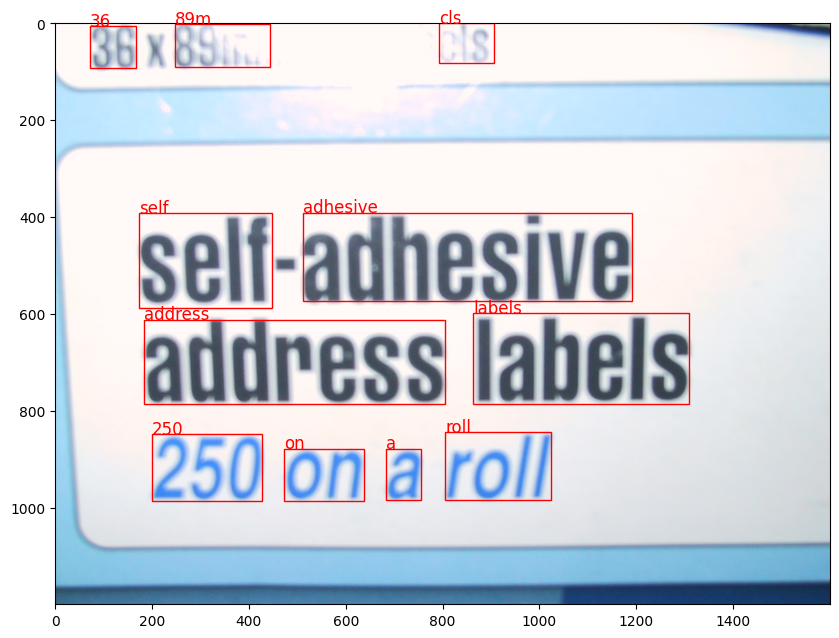

In [7]:
# plot image, bounding boxes and labels

def plot_image(image_path, image_size, labels, bbs):
    image = plt.imread(os.path.join(dataset_dir, image_path))
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    for label, bb in zip(labels, bbs):
        x, y, w, h = bb
        plt.gca().add_patch(
            plt.Rectangle(
                (x, y),
                w,
                h,
                linewidth=1,
                edgecolor="r",
                facecolor="none",
                label=label,
            )
        )
        plt.text(x, y, label, fontsize=12, color="r")

    plt.show()

plot_image(image_paths[0], image_sizes[0], image_labels[0], bounding_boxes[0])

## 3. Convert to YOLO format

In [9]:
def convert_to_yolo_format(image_paths, image_sizes, bounding_boxes):
    yolo_data = []

    for image_path, image_size, bboxes in zip(image_paths, image_sizes, bounding_boxes):
        image_width, image_height = image_size

        yolo_labels = []

        for bbox in bboxes:
            x, y, w, h = bbox

            # Calculate normalized bounding box coordinates
            center_x = (x + w / 2) / image_width
            center_y = (y + h / 2) / image_height
            normalized_width = w / image_width
            normalized_height = h / image_height

            # Because we only have one class, we set class_id to 0
            class_id = 0

            # Convert to YOLO format
            yolo_label = f"{class_id} {center_x} {center_y} {normalized_width} {normalized_height}"
            yolo_labels.append(yolo_label)

        yolo_data.append((image_path, yolo_labels))

    return yolo_data

In [12]:
# Define class labels
class_labels = ["text"]

# Convert data into YOLO format
yolo_data = convert_to_yolo_format(image_paths, image_sizes, bounding_boxes)
yolo_data[:2]

[('apanar_06.08.2002/IMG_1261.JPG',
  ['0 0.194375 0.40791666666666665 0.17125 0.1625',
   '0 0.5321875 0.40208333333333335 0.424375 0.1525',
   '0 0.309375 0.5825 0.38875 0.145',
   '0 0.67875 0.5770833333333333 0.27875 0.15583333333333332',
   '0 0.0746875 0.04125 0.059375 0.0725',
   '0 0.2159375 0.03833333333333333 0.123125 0.07333333333333333',
   '0 0.5309375 0.03375 0.071875 0.0675',
   '0 0.19625 0.7645833333333333 0.1425 0.11583333333333333',
   '0 0.3471875 0.7770833333333333 0.103125 0.09083333333333334',
   '0 0.4496875 0.7758333333333334 0.044375 0.08833333333333333',
   '0 0.571875 0.7620833333333333 0.13625 0.1175']),
 ('apanar_06.08.2002/IMG_1263.JPG',
  ['0 0.5346875 0.6008333333333333 0.529375 0.14333333333333334'])]

## 4. Train, val, test split

In [13]:
seed = 0
val_size = 0.2
test_size = 0.125
is_shuffle = True
train_data, test_data = train_test_split(
    yolo_data,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle,
)
test_data, val_data = train_test_split(
    test_data,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle,
)

## 5. Save data

In [14]:
def save_data(data, src_img_dir, save_dir):
    # Create folder if not exists
    os.makedirs(save_dir, exist_ok=True)

    # Make images and labels folder
    os.makedirs(os.path.join(save_dir, "images"), exist_ok=True)
    os.makedirs(os.path.join(save_dir, "labels"), exist_ok=True)

    for image_path, yolo_labels in data:
        # Copy image to images folder
        shutil.copy(
            os.path.join(src_img_dir, image_path), os.path.join(save_dir, "images")
        )

        # Save labels to labels folder
        image_name = os.path.basename(image_path)
        image_name = os.path.splitext(image_name)[0]

        with open(os.path.join(save_dir, "labels", f"{image_name}.txt"), "w") as f:
            for label in yolo_labels:
                f.write(f"{label}\n")

In [15]:
save_yolo_data_dir = "datasets/yolo_data"
os.makedirs(save_yolo_data_dir, exist_ok=True)
save_train_dir = os.path.join(save_yolo_data_dir, "train")
save_val_dir = os.path.join(save_yolo_data_dir, "val")
save_test_dir = os.path.join(save_yolo_data_dir, "test")

save_data(train_data, dataset_dir, save_train_dir)
save_data(test_data, dataset_dir, save_val_dir)
save_data(val_data, dataset_dir, save_test_dir)

In [16]:
# print size
print(f"Train data: {len(train_data)}")
print(f"Val data: {len(val_data)}")
print(f"Test data: {len(test_data)}")

Train data: 200
Val data: 7
Test data: 43


## 6. Create yaml file

In [21]:
data_yaml = {
    "path": "datasets/yolo_data",
    "train": "train/images",
    "test": "test/images",
    "val": "val/images",
    "nc": 1,
    "names": class_labels,
}

yolo_yaml_path = "data.yaml"
with open(yolo_yaml_path, "w") as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

## 7. Training

In [22]:
%%time
from ultralytics import YOLO

# Load a model
model = YOLO("yolo11m.pt")

# Train model
results = model.train(
    data=yolo_yaml_path,
    epochs=100,
    imgsz=640,
    cache=True,
    patience=20,
    plots=True,
)

Ultralytics 8.3.57 🚀 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 5938MiB)
engine/trainer: task=detect, mode=train, model=yolo11m.pt, data=data.yaml, epochs=100, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=True, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, sh

RuntimeError: Dataset 'data.yaml' error ❌ 
Dataset 'data.yaml' images not found ⚠️, missing path '/home/hongong/working/aio2024/scene-text-recoginition-ocr/datasets/datasets/yolo_data/val/images'
Note dataset download directory is '/home/hongong/working/aio2024/scene-text-recoginition-ocr/datasets'. You can update this in '/home/hongong/.config/Ultralytics/settings.json'

## 8. Evaluation

In [19]:
from ultralytics import YOLO

model_path = "runs/detect/train/weights/best.pt"
model = YOLO(model_path)

metrics = model.val()

Ultralytics 8.3.52 🚀 Python-3.10.16 torch-2.0.1 CUDA:0 (NVIDIA GeForce RTX 3060, 11931MiB)
YOLO11m summary (fused): 303 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


val: Scanning /home/aivn12s2/Desktop/Duc/AIO/Module-6/Image-Project/datasets/yolo_data/val/labels.cache... 43 images, 2 backgrounds, 0 corrupt: 100%|██████████| 43/43 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.76it/s]


                   all         43        200      0.879       0.93      0.936      0.745
Speed: 1.7ms preprocess, 11.8ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/val


## 9. Inference

In [20]:
import json

import cv2
import matplotlib.pyplot as plt


def visualize_bbox(
    img_path, predictions, conf_thres=0.8, font=cv2.FONT_HERSHEY_SIMPLEX
):
    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    for prediction in predictions:
        conf_score = prediction["confidence"]

        if conf_score < conf_thres:
            continue

        bbox = prediction["box"]
        xmin = int(bbox["x1"])
        ymin = int(bbox["y1"])
        xmax = int(bbox["x2"])
        ymax = int(bbox["y2"])

        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 3)

        text = f"{conf_score:.2f}"
        (text_width, text_height), _ = cv2.getTextSize(text, font, 1, 2)

        cv2.rectangle(
            img,
            (xmin, ymin - text_height - 5),
            (xmin + text_width, ymin),
            (0, 255, 0),
            -1,
        )
        cv2.putText(img, text, (xmin, ymin - 5), font, 1, (0, 0, 0), 2)

    return img

In [ ]:
from ultralytics import YOLO

model_path = "runs/detect/train/weights/best.pt"
img_path = "datasets/SceneTrialTrain/apanar_06.08.2002/IMG_1255.JPG"
conf_thres = 0.75
model = YOLO(model_path)

# Run inference
results = model(img_path, verbose=False)
predictions = json.loads(results[0].to_json())
visualized_img = visualize_bbox(img_path, predictions, conf_thres)

%matplotlib inline
plt.imshow(visualized_img)
plt.axis("off")
plt.show()